# Определение выгодного тарифа для телеком компании

# Описание проекта

Многие клиенты мобильного оператора пользуются архивными тарифами. Требуется построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф.

Есть данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

# Оглавление

* [1. Описание данных](#chapter1)
* [2. Разделение на выборки](#chapter2)
* [3. Исследование качества моделей](#chapter3)
    * [3.1. Решающее дерево](#section_3_1)
    * [3.2. Случайный лес](#section_3_2)
    * [3.3. Логистическая регрессия](#section_3_3)
* [4. Проверка моделей на тестовой выборке](#chapter4)
* [5. Общий вывод](#chapter5)

# 1. Описание данных <a class="anchor" id="chapter1"></a>

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import timeit

In [10]:
df = pd.read_csv('datasets/users_behavior.csv')


In [11]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [12]:
df.shape

(3214, 5)

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# 2. Разделение на выборки <a class="anchor" id="chapter2"></a>

Сохраним признаки в отдельных переменных:
- features — признаки;
- target — целевой признак.

In [13]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в пропорции 3-1-1

In [14]:
"""
Функция возвращает обучающую, валидационную и тестовую выборки.
val_size - часть от исходной выборки
test_size - часть от исходной выборки
"""
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state) 
    
    val_size = val_size/(1-test_size)
    
    X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=val_size, random_state=random_state) # 0.25 x 0.8 = 0.2
    
    return (X_train, X_val, X_test, y_train, y_val, y_test)

Сохраним результат выполнения функции `train_val_test_split` в соответствующих переменных.

In [15]:
features_train, features_val, features_test, target_train, target_val, target_test = \
train_val_test_split(features, target, random_state=123)

In [16]:
# КОД РЕВЬЮВЕРА

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_val.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.6
--> валидация 0.2
--> тест 0.2


In [17]:
# Функция возвращает имя датафрейма
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [18]:
# Функция возвращает размеры переданных датафреймов
def shapes(lst):
    for i in lst:
        print('Размер',get_df_name(i),'\t:',i.shape)

Проверим, каких размеров в итоге получились выборки с признаками и с ответами.

In [19]:
shapes([features_train, features_val, features_test, target_train, target_val, target_test])

Размер features_train 	: (1928, 4)
Размер features_val 	: (643, 4)
Размер features_test 	: (643, 4)
Размер target_train 	: (1928,)
Размер target_val 	: (643,)
Размер target_test 	: (643,)


Мы разделили датафрейм на обучающую, валидационную и тестовую выборки.

# 3. Исследование качества моделей <a class="anchor" id="chapter3"></a>

Поиграемся с различными метриками:
- Accuracy
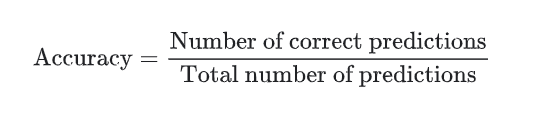
- Precision
- Recall
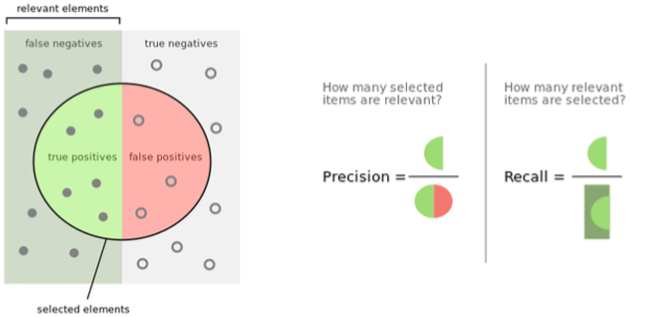
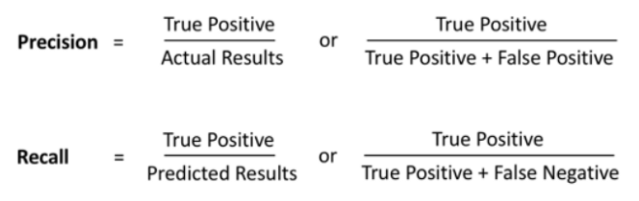
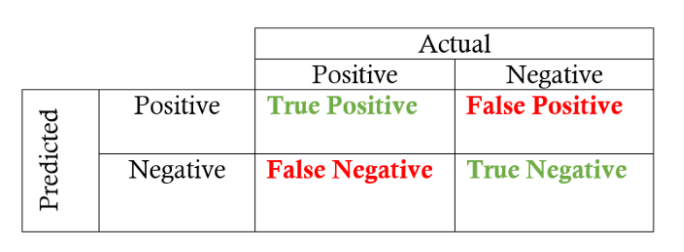
- F1
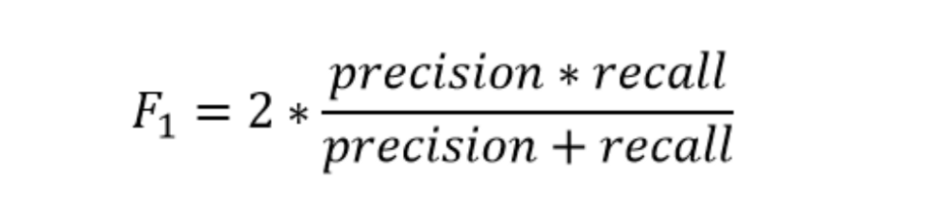

## 3.1. Решающее дерево <a class="anchor" id="section_3_1"></a>

Напишем функцию для обучения модели решающего дерева с выбором лучшей модели по метрике, заданной в параметре.

In [20]:
# Функция возвращает лучшую обученную модель дерева по указанной метрике
def best_tree_on_metric(X_train, y_train, X_val, y_val, metric, random_state=123, tree_depth=5, avg='micro'):
    best_model = None
    best_result = 0
    best_depth = 0
    for depth in range(1, tree_depth):
        model = DecisionTreeClassifier(random_state=random_state, max_depth=depth) # Создаём объект структуры данных
        model.fit(X_train, y_train) # Обучаем модель
        predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 
        
        
        if metric == 'accuracy':
            result = accuracy_score(y_val, predictions) 
            # Доля правильных ответов модели 
            """
            accuracy = [количество правильных ответов] / [всего вопросов]
            """
        elif metric == 'precision':
            result = precision_score(y_val, predictions, average=avg)
            # Точность 
            """
            The precision is the ratio tp / (tp + fp) where tp is the number of true positives 
            and fp the number of false positives. The precision is intuitively the ability 
            of the classifier not to label as positive a sample that is negative.
            The best value is 1 and the worst value is 0.
            """
        elif metric == 'recall':
            result = recall_score(y_val, predictions, average=avg)
            # Полнота 
            """
            The recall is the ratio tp / (tp + fn) where tp is the number of true 
            positives and fn the number of false negatives. The recall is intuitively the ability 
            of the classifier to find all the positive samples
            """
        elif metric == 'f1':
            result = f1_score(y_val, predictions, average=avg)
            # F1
            """
            The F1 score can be interpreted as a weighted average of the precision and recall, 
            where an F1 score reaches its best value at 1 and worst score at 0. 
            The relative contribution of precision and recall to the F1 score are equal. 
            The formula for the F1 score is:
            F1 = 2 * (precision * recall) / (precision + recall)
            """        
                 
        #print (result)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
    print(metric, "лучшей модели:", best_result)
    print("глубина дерева лучшей модели:", best_depth)
    return best_model;

In [ ]:
def roc_plot(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # границы осей от 0 до 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

Посмотрим, будет ли разница в показателях. Вызовем функцию `best_tree_on_metric` , задав макисмальную глубину дерева `tree_depth=10` при различных значениях параметра `metric`. 

In [21]:
%time best_tree = best_tree_on_metric(features_train, target_train, features_val, target_val, 'accuracy', tree_depth=10)

accuracy лучшей модели: 0.7947122861586314
глубина дерева лучшей модели: 9
CPU times: user 66.5 ms, sys: 486 µs, total: 67 ms
Wall time: 81.7 ms


In [22]:
best_tree_on_metric(features_train, target_train, features_val, target_val, 'precision', tree_depth=10)

precision лучшей модели: 0.7947122861586314
глубина дерева лучшей модели: 9


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [23]:
best_tree_on_metric(features_train, target_train, features_val, target_val, 'recall', tree_depth=10)

recall лучшей модели: 0.7947122861586314
глубина дерева лучшей модели: 9


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [24]:
best_tree_on_metric(features_train, target_train, features_val, target_val, 'f1', tree_depth=10)

f1 лучшей модели: 0.7947122861586314
глубина дерева лучшей модели: 9


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

Мы получили одинаковые показатели качества для дерева. Возьмем `accuracy` и будем использовать его вдальнейшем.

## 3.2. Случайный лес <a class="anchor" id="section_3_2"></a>

Напишем функцию для обучения модели случайного леса с выбором лучшей модели по Accuracy.

In [25]:
# Функция возвращает лучшую обученную модель леса деревьев по Accuracy
def best_forest_on_accuracy(X_train, y_train, X_val, y_val, random_state=123, n_estimators=10):
    t = timeit.timeit()
    best_model = None
    best_result = 0
    best_est = 0
    for est in range(1, n_estimators):
        
        
        model = RandomForestClassifier(random_state=random_state, n_estimators=est) # Создаём объект структуры данных
        model.fit(X_train, y_train) # Обучаем модель
        predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 

        result = accuracy_score(y_val, predictions) 
                 
        #print (est, result)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
    print("accuracy лучшей модели:", best_result)
    print("количество деревьев лучшей модели:", best_est)
    return best_model;

In [26]:
%time best_forest = best_forest_on_accuracy(features_train, target_train, features_val, target_val, n_estimators=40)

accuracy лучшей модели: 0.8009331259720062
количество деревьев лучшей модели: 22
CPU times: user 4.64 s, sys: 26.6 ms, total: 4.67 s
Wall time: 4.71 s


## 3.3. Логистическая регрессия <a class="anchor" id="section_3_3"></a>

Напишем функцию для обучения модели логистической регрессии.

In [27]:
# Функция возвращает обученную модель логистической регрессии
def logistic_accuracy(X_train, y_train, X_val, y_val, random_state=123):
    model = LogisticRegression(random_state=random_state) # Создаём объект структуры данных
    model.fit(X_train, y_train) # Обучаем модель
    predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 

    result = accuracy_score(y_val, predictions) 
    print("accuracy модели логистической регрессии:", result)
    return model

In [28]:
%time logistic_regression = logistic_accuracy(features_train, target_train, features_val, target_val)

accuracy модели логистической регрессии: 0.702954898911353
CPU times: user 16.7 ms, sys: 74 µs, total: 16.8 ms
Wall time: 15.5 ms


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


__________________________

Сведем результаты валидации по трём моделям в таблицу.

In [29]:
compare_val = pd.DataFrame({
    'Модель': ['Решающее дерево','Случайный лес','Логистическая регрессия'],
    'Accuracy': [0.7947122861586314,0.8009331259720062,0.7340590979782271],
    'Качество': ['Среднее','Высокое','Низкое'],
    'Скорость': ['Средняя','Низкая','Высокая']
})
compare_val

,Модель,Accuracy,Качество,Скорость
0,Решающее дерево,0.794712,Среднее,Средняя
1,Случайный лес,0.800933,Высокое,Низкая
2,Логистическая регрессия,0.734059,Низкое,Высокая


Мы обучили три модели, теперь опробуем их на тесте.

# 4. Проверка моделей на тестовой выборке <a class="anchor" id="chapter4"></a>

Поместим результаты предсказаний наших трёх моделей в переменные.

In [35]:
best_tree_predictions = best_tree.predict(features_test)
best_forest_predictions = best_forest.predict(features_test)
logistic_regression_predictions = logistic_regression.predict(features_test)

In [36]:
# Функция для подсчёта ошичных предсказаний
def error_count(answers, predictions):
    errors = 0
    for row in range(0, len(predictions)):
        if answers[row] != predictions[row]:
                     errors += 1
    return errors

In [37]:
# Функция для подсчёта доли правильных ответов
def accuracy(answers, predictions):
    accuracy = (len(answers) - error_count(answers, predictions))/len(answers)
    return accuracy

In [38]:
def check_models(test_target, test_predictions, model_name):
    print(model_name, "Errors:",error_count(test_target.reset_index(drop=True), test_predictions))
    print(model_name, "Accuracy:", accuracy(test_target.reset_index(drop=True), test_predictions))

Результаты тестирования:

In [39]:
check_models(target_test, best_tree_predictions, 'Best Tree')

Best Tree Errors: 137
Best Tree Accuracy: 0.7869362363919129


In [40]:
check_models(target_test, best_forest_predictions, 'Best Forest')

Best Forest Errors: 128
Best Forest Accuracy: 0.8009331259720062


In [41]:
check_models(target_test, logistic_regression_predictions, 'Logistic Regression')

Logistic Regression Errors: 191
Logistic Regression Accuracy: 0.702954898911353


In [42]:
compare_test = pd.DataFrame({
    'Модель': ['Решающее дерево','Случайный лес','Логистическая регрессия'],
    'Accuracy': [0.7869362363919129,0.8009331259720062,0.7511664074650077],
    'Качество': ['Среднее','Высокое','Среднее'],
    'Скорость': ['Средняя','Низкая','Высокая']
})
compare_test

,Модель,Accuracy,Качество,Скорость
0,Решающее дерево,0.786936,Среднее,Средняя
1,Случайный лес,0.800933,Высокое,Низкая
2,Логистическая регрессия,0.751166,Среднее,Высокая


In [43]:
target_test.value_counts() / features_test.shape[0]

0    0.699844
1    0.300156
Name: is_ultra, dtype: float64

In [44]:
from sklearn.metrics import roc_auc_score

# для подсчета auc нам нужно брать не предсказанный класс, а вероятность принадлежности к классу
prob = best_forest.predict_proba(features_test)[:, 1]

print('AUC случаного леса на тесте', roc_auc_score(target_test, prob))

# Видим, что AUC того же леса получше, чем у случайной модели => лес вполне адекватен

AUC случаного леса на тесте 0.7749913644214163


# 5. Общий вывод <a class="anchor" id="chapter5"></a>

**1. Качество.**

- Самое высокое качество у случайного леса.
- На втором месте оказалась модель дерева решений.
- Самая низкое (но не критично низкое по сравнению с решающим деревом) показала модель логистической регрессии. 

**2. Скорость работы.**

- Самая высокая скорость работы у логистической регрессии.
- Скорость решающего дерева тоже довольно высокая.
- Случайный лес медленнее всех.